# Introduction to Data Science
## Homework 4 

Student Name: Dhaval Popat

Student Netid: dkp288
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def cleanBosonData(infile_name):
    
    # read the csv data file into a pandas dataframe
    clean_data = pd.read_csv(infile_name, header=0, index_col=0)
    
    # obtain the count of each label from the dataframe and store it in a dictionary for easy access
    count = dict(clean_data['Label'].value_counts())
    
    # determine the minority class (with least number of counts)
    minority_class = min(count, key=count.get)
    
    # create a list of labels and their corresponding numeric value
    labels = [minority_class]
    numeric = [1]
    for label in count:
        if label not in labels:
            labels.append(label)
            numeric.append(0)
    
    # create a feature Y with numeric label
    clean_data['Y'] = clean_data['Label'].replace(labels, numeric)
    
    # drop the feature Label
    clean_data = clean_data.drop('Label', axis=1)
    
    for feature in clean_data.columns:
        if any(clean_data[feature] == -999):
            clean_data[feature + '_mv'] = np.where(clean_data[feature] == -999, 1, 0)
            # replace -999 values with nan, so that -999 values don't change the mean
            clean_data[feature] = clean_data[feature].replace(-999, np.nan)
            clean_data[feature] = clean_data[feature].replace(np.nan, clean_data[feature].mean())
        
        if feature != 'Y':
            clean_data[feature] = preprocessing.scale(clean_data[feature])
    
    return clean_data

# cleanBosonData('boson_training_cut_2000.csv')

### Part 2: Basic evaluations (5 points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [2]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

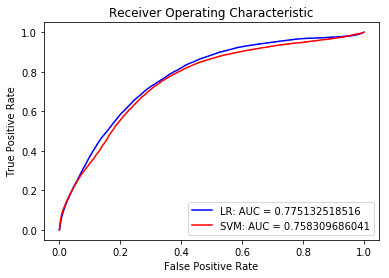

In [3]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

actual_values = data_test['Y']

logistic_regression = linear_model.LogisticRegression(C=1e30)
logistic_regression.fit(data_train.drop('Y',1), data_train['Y'])

svm_model = svm.SVC(kernel='linear')
svm_model.fit(data_train.drop('Y',1), data_train['Y'])

predictions = logistic_regression.decision_function(data_test.drop('Y',1))
lr_fpr, lr_tpr, thresholds = roc_curve(actual_values, predictions)
lr_roc = auc(lr_fpr, lr_tpr)

predictions = svm_model.decision_function(data_test.drop('Y',1))
svm_fpr, svm_tpr, thresholds = roc_curve(actual_values, predictions)
svm_roc = auc(svm_fpr, svm_tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(lr_fpr, lr_tpr, 'b', label='LR: AUC = ' + str(lr_roc))
plt.plot(svm_fpr, svm_tpr, 'r', label='SVM: AUC = ' + str(svm_roc))
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

The linear regression model is generally better at ranking the test set, as it is obvious from the AUC values for both models. There is a threshold value at tpr=0.2 and fpr=0.05 below which SVM model performs better and the linear regression model underperforms the SVM model.

### Part 3: Model selection with cross-validation (10 points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn import svm
import matplotlib.pyplot as plt

def xValSVM(dataset, label_name, k, cs):
    
    data = dataset.drop(label_name,1)
    target = dataset[label_name]
    aucs = {}
    
    for f in range(2,k):
        
        cv = KFold(n_splits = f)
        
        for index_train, index_validate in cv.split(X=data, y=target):
            
            data_train = dataset.iloc[index_train]
            data_validate = dataset.iloc[index_validate]
            
            for c in cs:
                
                svm_model = svm.SVC(kernel='linear', C=c)
                svm_model.fit(data_train.drop(label_name,1),data_train[label_name])
                
                predictions = svm_model.decision_function(data_validate.drop(label_name,1))
                fpr, tpr, thresholds = roc_curve(data_validate[label_name], predictions)
                score = auc(fpr, tpr)
                
                if c in aucs:
                    aucs[c].append(score)
                else:
                    aucs[c] = [score]
        
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

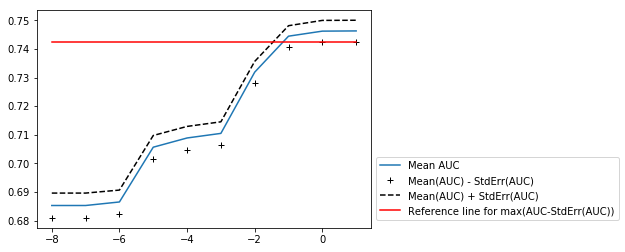

In [5]:
cs = [10**i for i in range(-8,2)]

aucs = xValSVM(data_train, 'Y', 10 , cs)

mean = []
std_error = []

for c in cs:
    mean.append(np.mean(aucs[c]))
    std_error.append(np.sqrt(np.var(aucs[c])/((len(aucs[c])))))

max_reference_line = np.ones(len(mean)) * (max(np.array(mean) - np.array(std_error)))

plt.plot(np.log10(cs), np.array(mean), label='Mean AUC')
plt.plot(np.log10(cs), np.array(mean)-np.array(std_error), 'k+', label='Mean(AUC) - StdErr(AUC)')
plt.plot(np.log10(cs), np.array(mean)+np.array(std_error), 'k--', label='Mean(AUC) + StdErr(AUC)')
plt.plot(np.log10(cs), max_reference_line, 'r', label='Reference line for max(AUC-StdErr(AUC))')

plt.legend(bbox_to_anchor = (1, 0.35))
plt.show()

Yes, the selected model parameters gave better results for out-of-the-box model for SVM. Although, it can be observed that mean AUC for SVM using cross validation, it has decreased as compared to initial AUC value for the SVM model. But if analysed the AUC for each c value, the model achieves an AUC of about 0.79 which is way better than previous results.

### Part 4: Learning Curve with Bootstrapping
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [6]:
import numpy as np
import statistics
import math

def modBootstrapper(train, test, nruns, sampsize, lr, c):
    
    aucs = []
    
    for i in range(nruns):
        training_sample = train.iloc[np.random.randint(0, len(train), size=sampsize)]
        
        if (lr == 1):
            logistic_regression = linear_model.LogisticRegression(C=1e30)
            logistic_regression.fit(training_sample.drop('Y',1), training_sample['Y'])
            prediction = logistic_regression.predict_proba(test.drop('Y',1))[:,1]
        
        else:
            svm_model = svm.SVC(kernel='linear', C=c)
            svm_model.fit(training_sample.drop('Y',1), training_sample['Y'])
            prediction = svm_model.decision_function(test.drop('Y',1))
        
        aucs.append(roc_auc_score(test['Y'], prediction))
    
    return np.mean(aucs), math.sqrt(statistics.variance(aucs)/nruns)

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


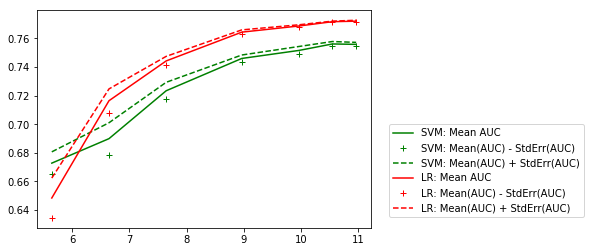

In [20]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

svm_mean = []
svm_std_error = []
lr_mean = []
lr_std_error = []

for samplesize in samplesizes:
    
    mean, std_error = modBootstrapper(data_train, data_test, 20, samplesize, 0, 100)
    svm_mean.append(mean)
    svm_std_error.append(std_error)
    
    mean, std_error = modBootstrapper(data_train, data_test, 20, samplesize, 1, 100)
    lr_mean.append(mean)
    lr_std_error.append(std_error)


plt.plot(np.log2(samplesizes), np.array(svm_mean), 'g', label='SVM: Mean AUC')
plt.plot(np.log2(samplesizes), np.array(svm_mean)-np.array(svm_std_error), 'g+', label='SVM: Mean(AUC) - StdErr(AUC)')
plt.plot(np.log2(samplesizes), np.array(svm_mean)+np.array(svm_std_error), 'g--', label='SVM: Mean(AUC) + StdErr(AUC)')

plt.plot(np.log2(samplesizes), np.array(lr_mean), 'r', label='LR: Mean AUC')
plt.plot(np.log2(samplesizes), np.array(lr_mean)-np.array(lr_std_error), 'r+', label='LR: Mean(AUC) - StdErr(AUC)')
plt.plot(np.log2(samplesizes), np.array(lr_mean)+np.array(lr_std_error), 'r--', label='LR: Mean(AUC) + StdErr(AUC)')


plt.legend(bbox_to_anchor = (1.65, 0.5))
plt.show()


3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


According to the results obtained from the above plot, SVM is more suitable for smaller sample sizes. I think it might be a worthy investment to run experiments to double the data, as the AUC value has increased from about 0.76 to 0.79. It is possible to achieve more AUC if the size of data increases.

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?



Generally k-fold cross-validation is biased for lower values of K. The larger values of K are more expensive. Hence, the values of K that we used in our modeling are initially too less (10^-8, 10^-7, etc). Later, better results are obtained when the value of K is increased to 10, which is like a trade-off value between bias and the variance.